In [1]:

import numpy as np 
import pandas as pd 
import os
import re


import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import Dict

import gc

from shutil import copyfile
copyfile(src = "/kaggle/input/eraser-movies/utils.py", dst = "../working/utils.py")
from utils import load_documents, load_datasets, annotations_from_jsonl, Annotation

# Loading the data

In [2]:
# Method that retrieves input from .xml file
def get_input(ann):
    if len(ann.all_evidences())==0:
        docid  = ann.annotation_id
    else:
        (docid,) = set(ev.docid for ev in ann.all_evidences())
    doc = documents[docid]
    input = ''
    for sent in doc:
        input += ' '.join(sent)
    return input



# Trainer dataset object used for model training. Kept for EDA for consistency of data loading between notebooks
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, evidences=None):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.evidences = evidences

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
#             token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])  



# Method that interprets inputs from .xml file into TrainerDataset objecct
def create_dataset(dataset, tokenizer):
    targets = [1  if ann.classification != 'NEG' else 0 for ann in dataset]
    evidences = [[ev.text for ev in ann.all_evidences()] for ann in dataset]
    inputs = [get_input(ann) for ann in dataset]
    
    if len(targets)==len(evidences)==len(inputs):
        return TrainerDataset(inputs, targets, tokenizer, evidences)
    else:
        print("Something went wrong !!!!!")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# Loading final datasets
data_root = '/kaggle/input/eraser-movies/movies'
documents = load_documents(data_root)

train, val, test = load_datasets(data_root)

train_dataset = create_dataset(train, tokenizer)
eval_dataset = create_dataset(val, tokenizer)
test_dataset = create_dataset(test, tokenizer)

df = pd.DataFrame(data={"text":train_dataset.inputs, "target":train_dataset.targets})
df.head()

,text,target
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard 's quick movie review damnth...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . 'first ...",0
4,synopsis : a mentally unstable man undergoing ...,0


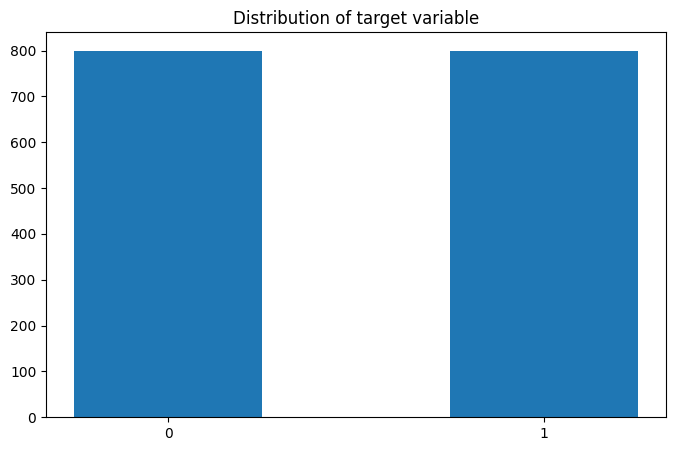

In [4]:
plt.figure(figsize =(8,5))
label, count = np.unique(df.target, return_counts=True)
plt.bar(label, count, width=1/2)
plt.xticks(label)
plt.title("Distribution of target variable")
plt.show()

In [5]:
# Method provides tokenization then removes special symbols like ; , . ' "
def tokenize_words_only(text):
    return [word for word in word_tokenize(text) if word not in [",",".", "?", "!", "...", ";", ":", "'", '"', "(", ")", "[", "]", "<", ">", "{", "}", "/", "|", '``', "-", "_"]]

In [6]:
from nltk.tokenize import word_tokenize

df["# of words"] = df.text.apply(lambda x: len(tokenize_words_only(x)))
df["length"] = df.text.apply(lambda x: len(x))


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


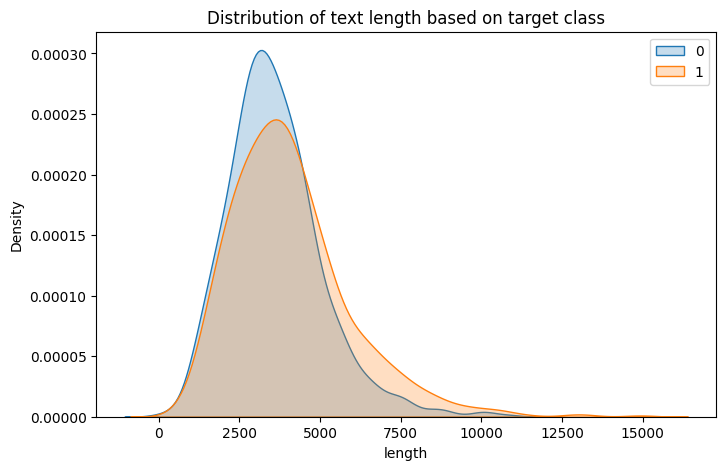

In [7]:
import seaborn as sns
plt.figure(figsize =(8,5))
for l in label:
    sns.kdeplot(df.length[df.target==l], fill=True, label=l)
plt.legend()
plt.title("Distribution of text length based on target class")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


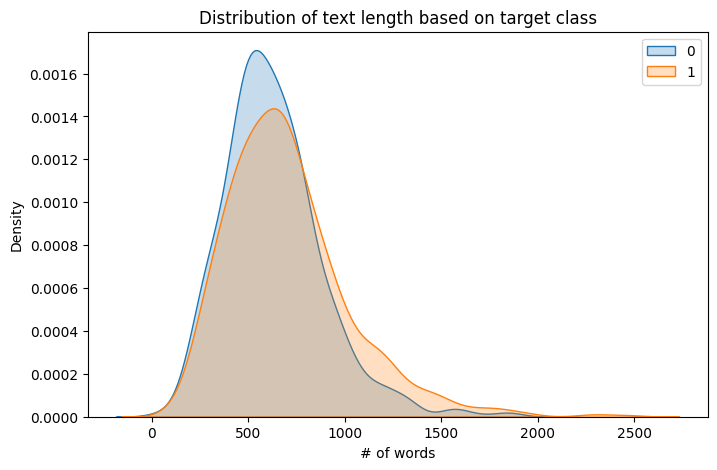

In [8]:
plt.figure(figsize =(8,5))
for l in label:
    sns.kdeplot(df["# of words"][df.target==l], fill=True, label=l)
plt.legend()
plt.title("Distribution of text length based on target class")
plt.show()

In [12]:
print(f"Number of observations: {len(df)}\nAverage number of words: {np.mean(df['# of words'])}")

Number of observations: 1600
Average number of words: 665.85375


# Most commonn words

In [10]:
from nltk.probability import FreqDist
from nltk.corpus import stopwords

fq = FreqDist(word.lower() for word in tokenize_words_only(" ".join(df.text)))
res = sorted([ [key,value] for key, value in dict(fq).items() if key not in stopwords.words('english')], key=lambda item: item[1])
res = pd.DataFrame(res[::-1])
res.columns = ["word", "count"]
res.head(20)

,word,count
0,'s,14556
1,film,7574
2,.the,5769
3,n't,4959
4,movie,4486
5,one,4246
6,like,2802
7,.it,2260
8,time,1901
9,good,1895


# Check for remains of HTML
Some NLP datasets are created by scraping the data from websides. This sometimes results in remains of HTML code (like < br > < /br >) left in the final dataset


In [11]:
for text in df.text:
    html = re.findall('<[^<]+?>',  text)
    if len(html)>0:
        print(html)